In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from src.load_data import *
from src.graphs import *
from src.statistical_tests import *
from src.utils import *

## Few notes:
* **total_clearance_between_visit** - wzgledem poprzedniej wizyty
* **clearance_between_visit** - wzgledem poczatku
* we group to **nereast** time group 


#### To-dos:
* Sprawdz ilosc grup z peaku w gory!
* Sprawdzic linear fit i non-linear fit
* Sprawdz rozne 
* Sprawdz methodologie
* Sila statystyczna (p-value)
* Sprawdz rozne kwartaly
* Pogrobic linie

#### Few **old** notes:
* The table above should include all information You need
* `wizyta po ilu zabiegach` -> can have some skipped zabiegy & can start at other point than 0
* `czas` -> defined as czas between this and next visit



In [2]:
data = get_data(format_type='all', remove_minus_ones = False)
non_moved_df = get_data(format_type='all')
moved_df = get_data(format_type='moved_to_0')
non0s_df = get_data(format_type='all_without_0s')

print('looking at the data:')
data.head(10)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
looking at the data:


,surname,time,summed_time,time_group,visit_number,total_clearence_in_between_visits,total_clearence_in_respect_to_beginning,------------
0,1.Gasek,57,57,1,1,10.43594,10.435942,
1,1.Gasek,958,1015,4,2,-1.90988,8.725376,
2,1.Gasek,70,1085,1,3,-3.15234,5.848092,
3,1.Gasek,63,1148,1,4,26.20423,30.519873,
4,1.Gasek,238,1386,3,5,-0.99610,29.827784,
5,2. Kołodziejska,217,217,2,1,66.95658,66.956580,
6,2. Kołodziejska,42,259,0,2,20.93472,73.874130,
7,2. Kołodziejska,21,280,0,4,-1.00000,81.844740,
8,2. Kołodziejska,26,306,0,5,-59.55360,71.032640,
9,2. Kołodziejska,294,600,3,6,76.67272,93.242700,


## Get ANOVA & ttest between buckets:

default time group has GROUPS defined as: [0, 90, 180, 270, 360]




anova results:
buckets: [1, 3, 6, 10, 15]
p_value: 7.392958551550948e-18

statistics between 1 - 2 bucket and 3 - 5 bucket
means: 23.53 vs 41.85
p-value: 0.0

statistics between 3 - 5 bucket and 6 - 9 bucket
means: 41.85 vs 54.09
p-value: 0.00015

statistics between 6 - 9 bucket and 10 - 14 bucket
means: 54.09 vs 53.04
p-value: 0.61438



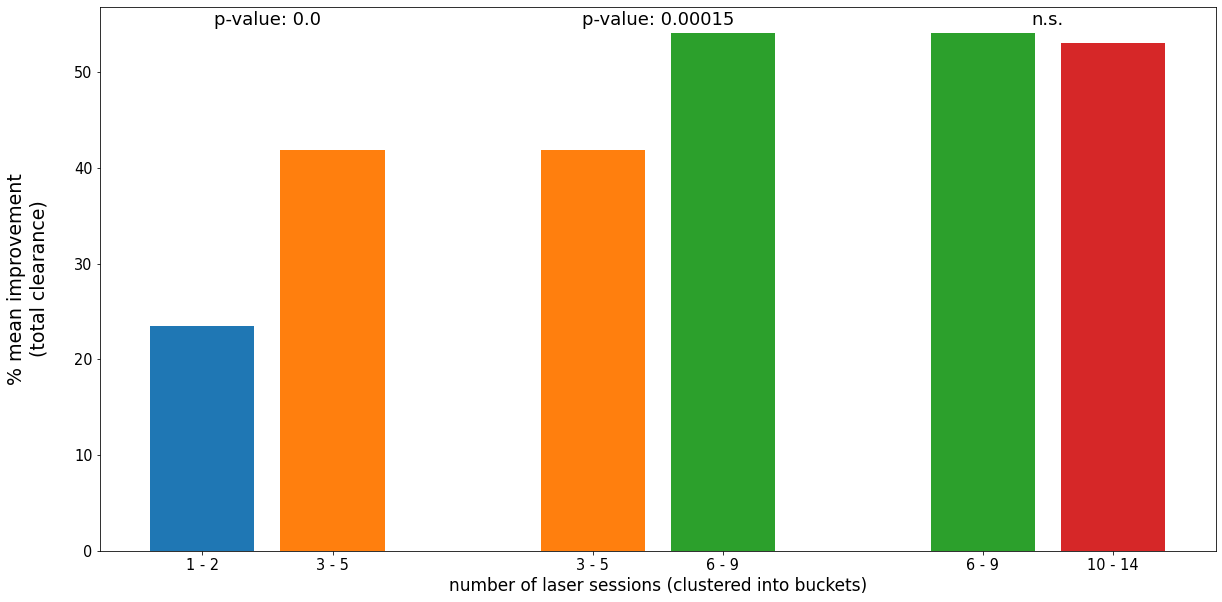

In [3]:
from src.statistical_tests import bucket_anova_n_plot
bucket_anova_n_plot()

### Stats for abstract:

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
median of maximum total clearence: 59.613085
% of patients that had a total_clearence of minimum 25%: 82.25806451612904
% of patients that had a total_clearence of minimum 50%: 67.74193548387096
% of patients that had a total_clearence of minimum 75%: 24.193548387096776
% of patients that had a total_clearence of minimum 90%: 4.838709677419355




default time group has GROUPS defined as: [0, 90, 180, 270, 360]
limit: 0. |% patients: 95.16
limit: 5. |% patients: 95.16
limit: 10. |% patients: 93.55
limit: 15. |% patients: 88.71
limit: 20. |% patients: 83.87
limit: 25. |% patients: 82.26
limit: 30. |% patients: 80.65
limit: 35. |% patients: 79.03
limit: 40. |% patients: 77.42
limit: 45. |% patients: 70.97
limit: 50. |% patients: 67.74
limit: 55. |% patients: 62.9
limit: 60. |% patients: 50.0
limit: 65. |% patients: 45.16
limit: 70. |% patients: 32.26
limit: 75. |% patients: 24.19
limit: 80. |% patients: 17.74
limit: 85. |% 

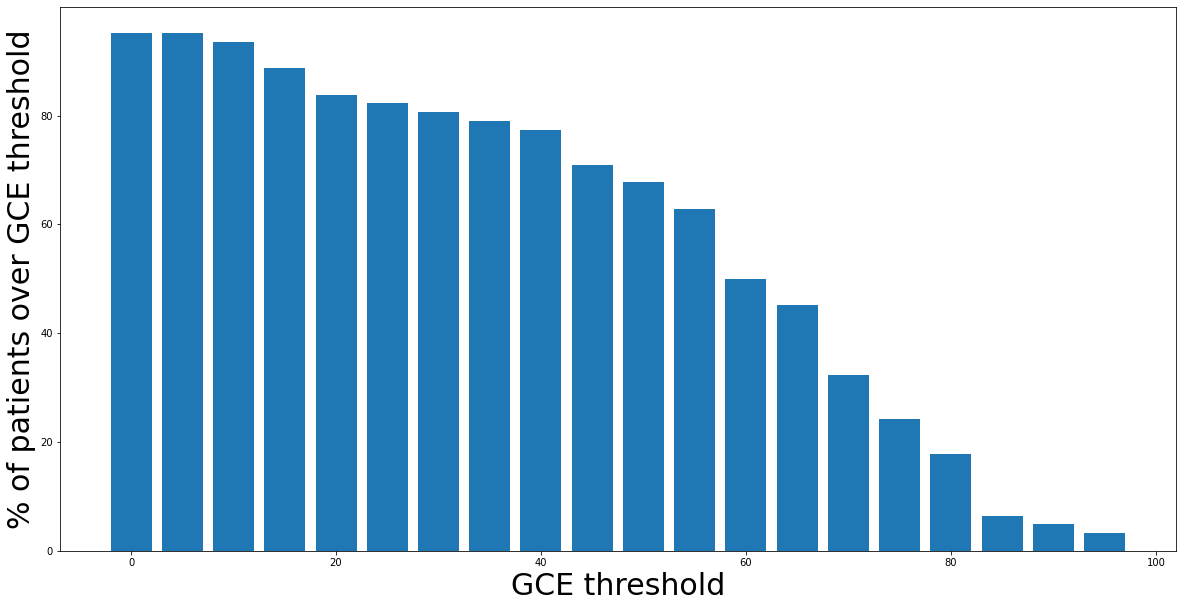

In [8]:
get_stats_for_abstract(df = None, format_type = 'all')
print("\n\n\n")
get_graph_GCE_vs_pct_people()

In [9]:
get_stats_for_abstract2(df = None, format_type = 'all', visit_number_buckets = [0,2,5,10,15,20])

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
bucket: 2
bucket: 5
bucket: 10
bucket: 15
bucket: 20
[29.24616, 45.51749, 56.58685316, 56.99166, 56.97438]


,surname,total_clearence_in_respect_to_beginning
0,1.Gasek,30.519873
1,10.Będzinowski szyja,60.169450
2,11. Cicha-kwiecień,52.934780
3,12. Januszewska,60.984150
4,13.Zborowski,77.379030
...,...,...
57,7. Kowal,82.977240
58,70. Wójcicki,83.173308
59,71. Zając,9.855161
60,8.Wierny,71.835400


In [28]:
data, expected_frequences = chi_squared_test(non_moved_df, name = 'example test', display_data = True)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
p-value of chi squred contigency test for example test: 0.001215366770283146 (w. Yates correction - good practice)


days passed,1-90,91-180,181-270,271 - 360,361+,type
mean improvement below 0,,,,,,
False,109,97,20,6,2,frequencies
True,55,38,8,5,11,frequencies


expected frequencies:


,1-90,91-180,181-270,271 - 360,361+,type
False,109.33,90.0,18.67,7.33,8.67,expected_frequences
True,54.67,45.0,9.33,3.67,4.33,expected_frequences


Chi squred contigency test p-value: 0.014


# Main Graphs
### Total clearence compared to start:

In [11]:
# plt.figure(figsize=(20,10))
# data = get_data(format_type='all',remove_minus_ones = False )
# data2 = get_data(format_type='moved_to_0',remove_minus_ones = False )
# data3 = get_data(format_type='all_without_0s',remove_minus_ones = False )
# agg_column_graph(data, label = 'data bez zmian', column = 'total_clearence_in_respect_to_beginning')
# agg_column_graph(data2, label = 'data moved to 0', column = 'total_clearence_in_respect_to_beginning')
# agg_column_graph(data3, label = 'data without patients without 1st visit', column = 'total_clearence_in_respect_to_beginning', title = 'title')

No handles with labels found to put in legend.


default time group has GROUPS defined as: [0, 90, 180, 270, 360]


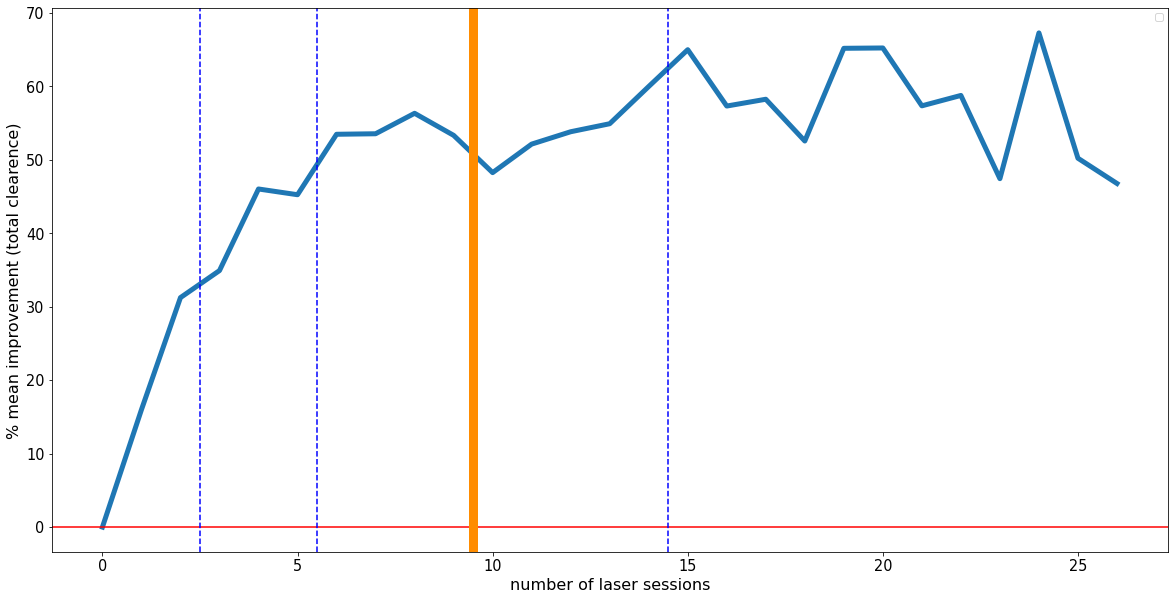

In [13]:
plt.figure(figsize=(20,10))
data = get_data(format_type='all',remove_minus_ones = False )
agg_column_graph(data, agg = 'mean', label = '', column = 'total_clearence_in_respect_to_beginning', title = '', cut_last_x_visits = 27)
plt.axvline(x=2.5, color='b', linestyle='--')
plt.axvline(x=5.5, color='b', linestyle='--')
plt.axvline(x=9.5, color='darkorange', linestyle='-',  lw = 9)
plt.axvline(x=14.5, color='b', linestyle='--')

# Logaithmic and polynomial fits
# If the logathmic fit is the best fit
# Anova -> posthoc ttest ()
# Plot the scatter of data for better visibility 
# (try moving avg for smoothen avg)

No handles with labels found to put in legend.


default time group has GROUPS defined as: [0, 90, 180, 270, 360]


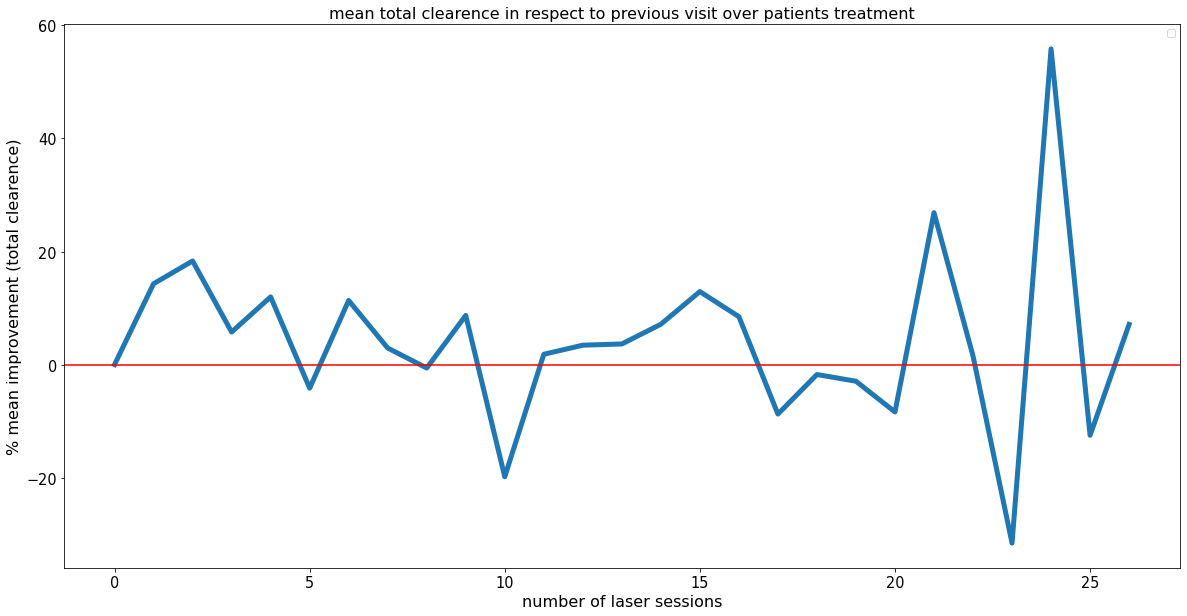

In [15]:
data = get_data(format_type='all',remove_minus_ones = True )
plt.figure(figsize=(20,10))
agg_column_graph(data, label = '', column = 'total_clearence_in_between_visits', title = 'mean total clearence in respect to previous visit over patients treatment', cut_last_x_visits = 26)

### Showcase of how tests works:

No handles with labels found to put in legend.


Pearsons correlation of the linear fit for : -0.973 (very bad practice though)
p-value of chi squred contigency test for : nan (w. Yates correction - good practice)



,nr_visit_group,patients_in_bucket
0,0,199
1,10,128
2,20,24


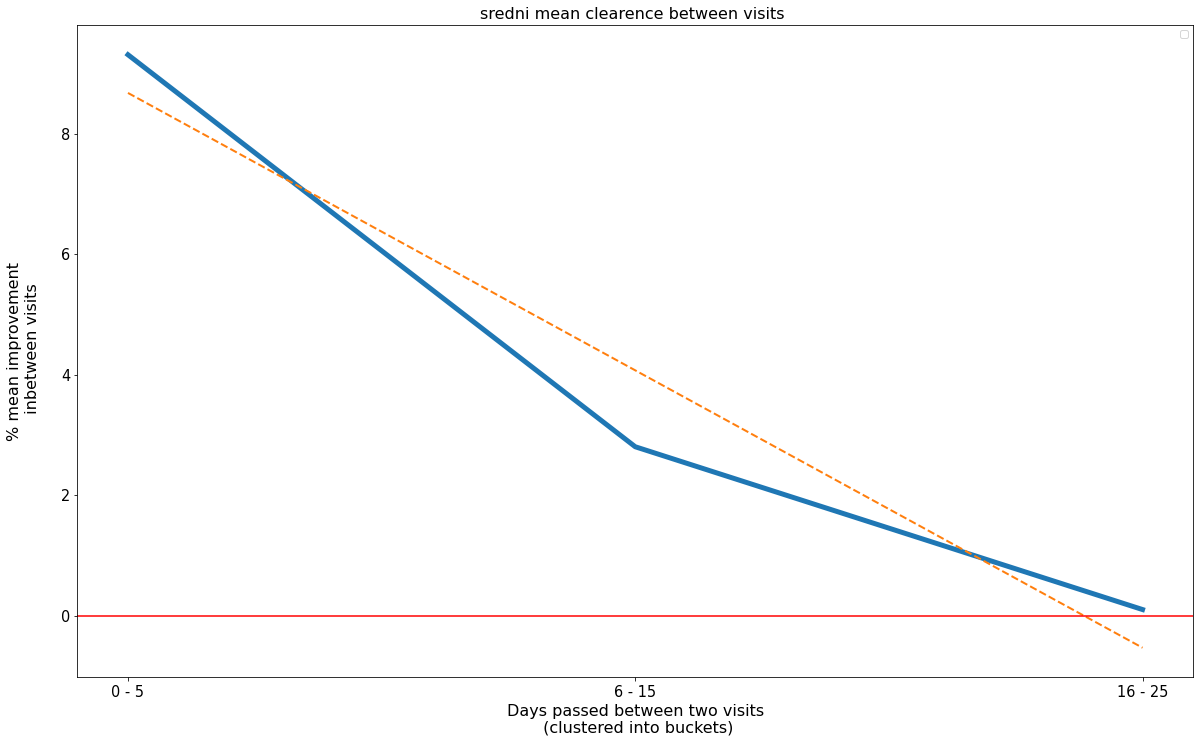

In [29]:
plt.figure(figsize=(20,12))
time_group_based_avg_graph(moved_df, 
                           GROUPS = [0,10,20], 
                           increment = 10, 
                           display_data_for_chi_square_test = False, 
                           base_column = 'nr_visit_group',
                           column = 'total_clearence_in_between_visits')

In [32]:
# plt.figure(figsize=(20,12))
# a = time_group_based_avg_graph(non_moved_df, 
#                            GROUPS = [0,5,10,15,20], 
#                            increment = 5, 
#                            display_data_for_chi_square_test = False, 
#                            base_column = 'nr_visit_group',
#                            column = 'total_clearence_in_between_visits',
#                            label = 'nie przesunieci')
# time_group_based_avg_graph(moved_df, 
#                            GROUPS = [0,5,10,15,20], 
#                            increment = 5, 
#                            display_data_for_chi_square_test = False, 
#                            base_column = 'nr_visit_group',
#                            column = 'total_clearence_in_between_visits',
#                            label = 'przesunieci')

# time_group_based_avg_graph(non0s_df, 
#                            GROUPS = [0,5,10,15,20], 
#                            increment = 5, 
#                            display_data_for_chi_square_test = False, 
#                            base_column = 'nr_visit_group',
#                            column = 'total_clearence_in_between_visits',
#                            label = 'usunieci bez 1 wizyty')
# display(a)
# plt.title('mean total_clearencs vs nr_visits group')
# plt.xlabel('nr_visits_group')

## Time Group based avg graphs:
* Removed graphs for patients after 15th and 20th visit - since there is barely any data there

In [33]:
# graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,100,200], increment = 100)

In [34]:
# graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,200,400], increment = 200)

In [35]:
# graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,100,200,300], increment = 100) # I dont like this one

## Answer to new question asked by Professor:
mam pytanie do Janka, tak jak zobaczyliśmy, że lepiej jest robić wizyty co 90-180 dni czyli co mniej więcej 180 dni, moje pytanie o to czy w fazie do 9 wizyt warto jest robić zabiegi co 4 tygodnie tak jak prosimy czy może jednak co 90 dni. Jest chińska praca na dzieciach, która sugeruje, że co 6 tygodni jest lepiej niż co 2 (ten sam efekt po 3 vs 6 zabiegach) w tym samym czasie. te rozbieżności były zawsze, ale może można spróbować wyszukać optymalnej częstotliwości na podstawie naszych danych?

In [36]:
print([i*56 for i in range(50)])

[0, 56, 112, 168, 224, 280, 336, 392, 448, 504, 560, 616, 672, 728, 784, 840, 896, 952, 1008, 1064, 1120, 1176, 1232, 1288, 1344, 1400, 1456, 1512, 1568, 1624, 1680, 1736, 1792, 1848, 1904, 1960, 2016, 2072, 2128, 2184, 2240, 2296, 2352, 2408, 2464, 2520, 2576, 2632, 2688, 2744]


default time group has GROUPS defined as: [0, 90, 180, 270, 360]
p-value of chi squred contigency test for wizyty 29 i blizsze: 0.0004542617420647846 (w. Yates correction - good practice)

p-value of chi squred contigency test for wizyty 15 i blizsze: 0.0015423926999728475 (w. Yates correction - good practice)

p-value of chi squred contigency test for wizyty 9 i blizsze: 0.009119548941590774 (w. Yates correction - good practice)

p-value of chi squred contigency test for wizyty 9 i blizsze: 0.47059819765872224 (w. Yates correction - good practice)

p-value of chi squred contigency test for wizyty 15 i blizsze: 0.33757660652658295 (w. Yates correction - good practice)

p-value of chi squred contigency test for wizyty 30 i blizsze: 0.34386207575381594 (w. Yates correction - good practice)

p-value of chi squred contigency test for wizyty 9 i blizsze: 0.09081538471591066 (w. Yates correction - good practice)

p-value of chi squred contigency test for wizyty 15 i blizsze: nan (w. Yates co

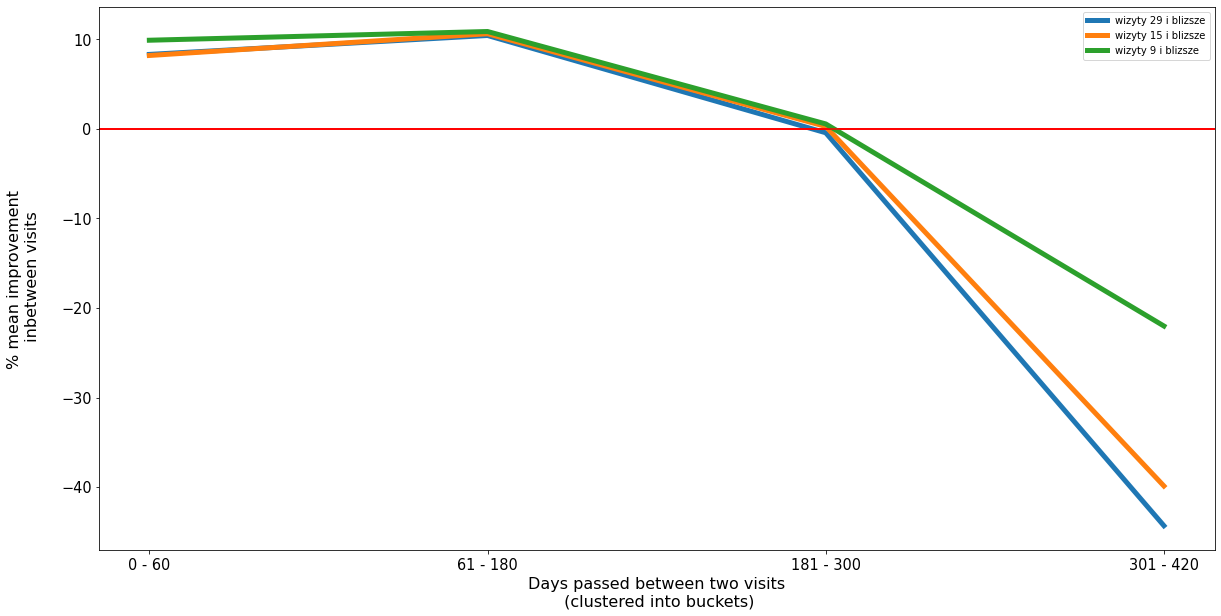

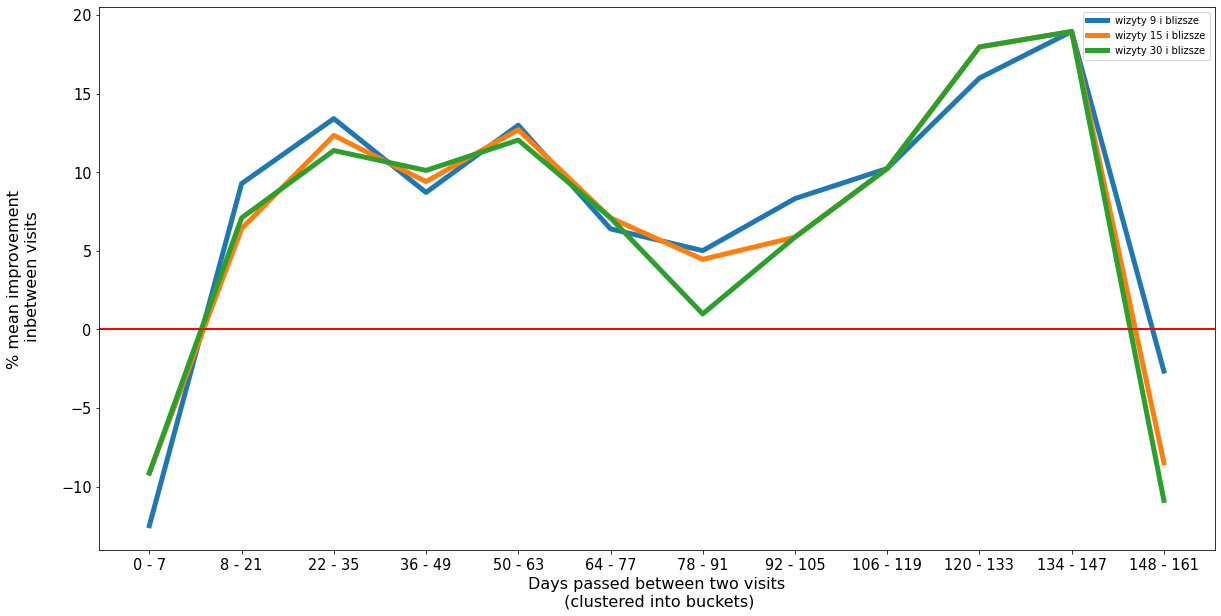

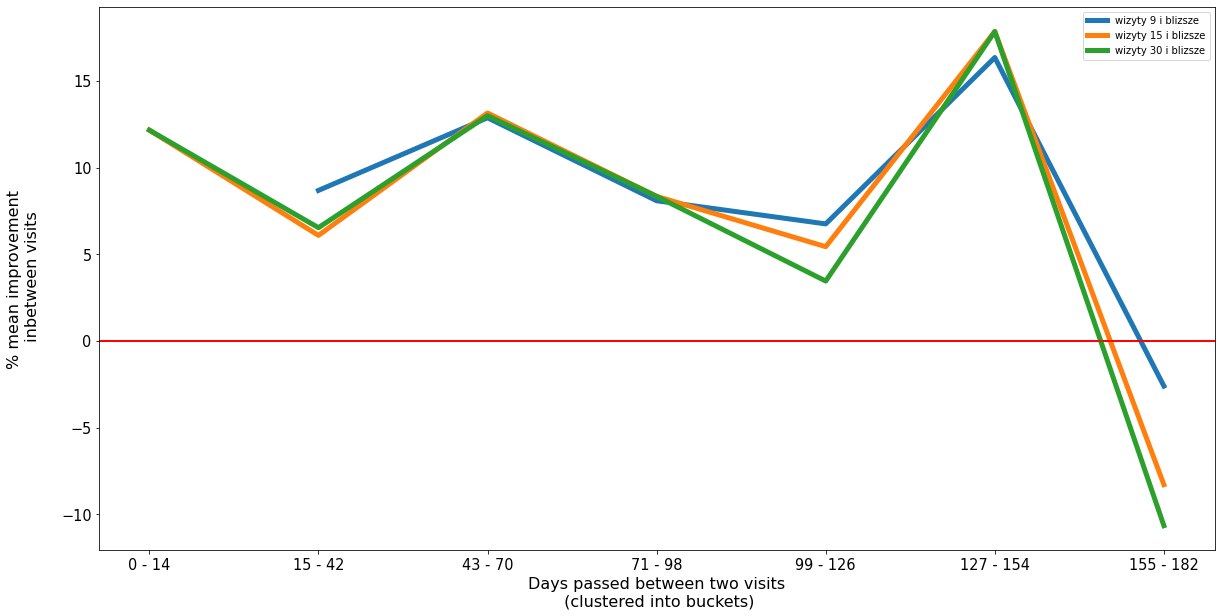

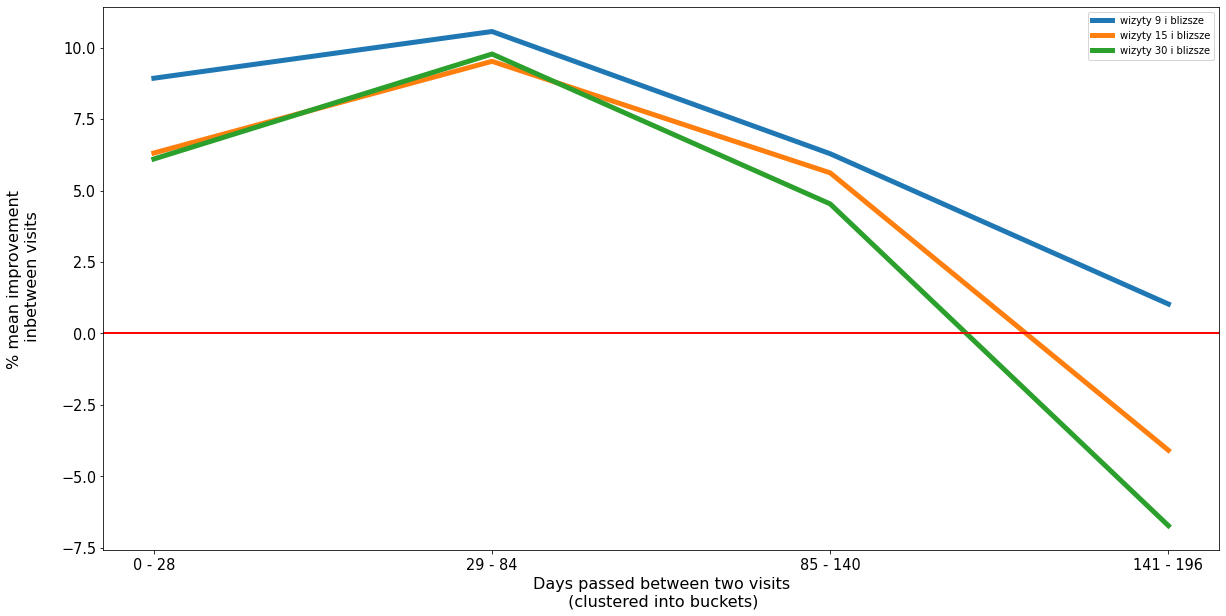

In [37]:
def answer():
    data = get_data(format_type='all',remove_minus_ones = True )
    # data_up_to_9th = data.loc[data.visit_number <= 9]
    # data_up_to_5th = data.loc[data.visit_number <= 5]
    # data_up_to_15th = data.loc[data.visit_number <= 15]
    a = graph_multiple_time_group_based_avg_graph(data, blizsze = True, GROUPS = [0,120,240,360], increment = 120, skip_linear_fit = True, wizyty_iteration = [29,15,9])
    # graph_multiple_time_group_based_avg_graph(data, blizsze = True, GROUPS = [0,90,180,270], increment = 90, skip_linear_fit = True, wizyty_iteration = [29,15,9])
    b = graph_multiple_time_group_based_avg_graph(data, blizsze = True, GROUPS = [0, 14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168], increment = 14, skip_linear_fit = True, wizyty_iteration = [9,15,30])
    c = graph_multiple_time_group_based_avg_graph(data, blizsze = True, GROUPS = [0, 28, 56, 84, 112, 140, 168], increment = 28, skip_linear_fit = True, wizyty_iteration = [9,15,30])
    d = graph_multiple_time_group_based_avg_graph(data, blizsze = True, GROUPS = [0, 56, 112, 168], increment = 56, skip_linear_fit = True, wizyty_iteration = [9,15,30])
    return a,b,c,d


a,b,c,d = answer()

In [38]:
display(a)
display(d)
display(c)
display(b)

,time_group,patients_in_bucket wizyty 29 i blizsze,patients_in_bucket wizyty 15 i blizsze,patients_in_bucket wizyty 9 i blizsze
0,0,219,202,158
1,120,94,90,77
2,240,25,21,15
3,360,13,11,9


,time_group,patients_in_bucket wizyty 9 i blizsze,patients_in_bucket wizyty 15 i blizsze,patients_in_bucket wizyty 30 i blizsze
0,0,50,61,64
1,56,146,188,205
2,112,30,32,33
3,168,33,43,49


,time_group,patients_in_bucket wizyty 9 i blizsze,patients_in_bucket wizyty 15 i blizsze,patients_in_bucket wizyty 30 i blizsze
0,0,0,1,1
1,28,107,141,155
2,56,66,80,86
3,84,34,38,38
4,112,15,17,18
5,140,8,9,9
6,168,29,38,44


,time_group,patients_in_bucket wizyty 9 i blizsze,patients_in_bucket wizyty 15 i blizsze,patients_in_bucket wizyty 30 i blizsze
0,0,0,0,0
1,14,2,5,5
2,28,81,103,113
3,42,42,58,65
4,56,41,49,51
5,70,18,19,20
6,84,19,22,22
7,98,8,9,10
8,112,6,7,7
9,126,6,6,6


## --- End of the quick answer

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
p-value of chi squred contigency test for visits with nunber 5 and further: 0.11189111616267237 (w. Yates correction - good practice)

p-value of chi squred contigency test for all visits: 0.0004542617420647846 (w. Yates correction - good practice)



,time_group,patients_in_bucket visits with nunber 5 and further,patients_in_bucket all visits
0,0,125,219
1,120,57,94
2,240,23,25
3,360,6,13


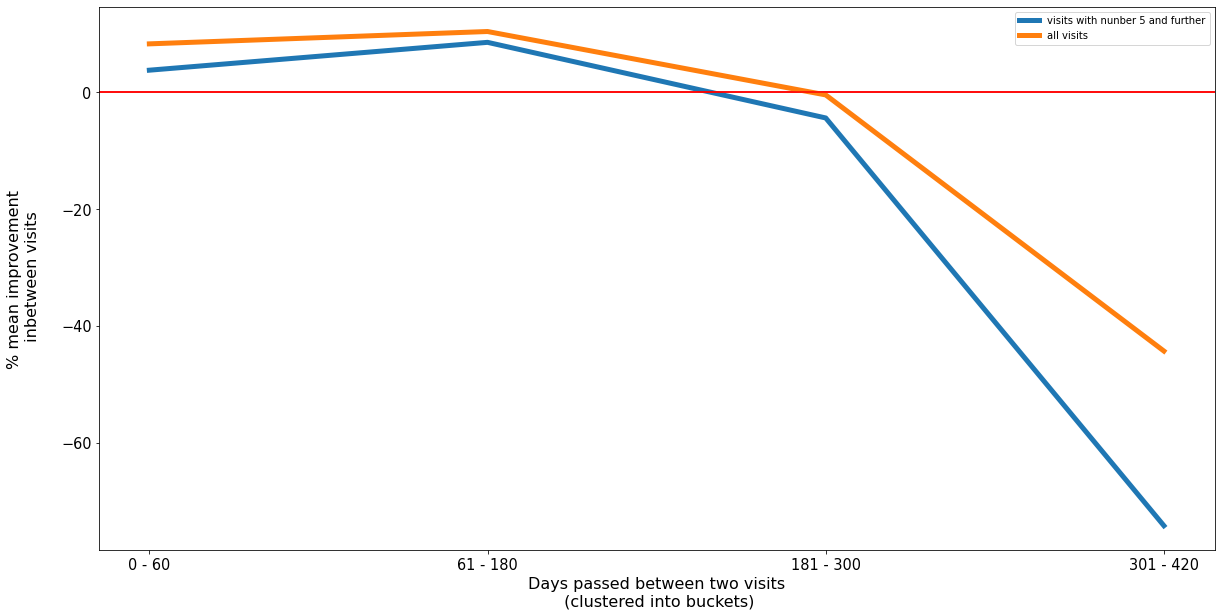

In [39]:
data = get_data(format_type='all',remove_minus_ones = True )
graph_multiple_time_group_based_avg_graph(data,blizsze = False, GROUPS = [0,120,240,360], increment = 120, skip_linear_fit = True, wizyty_iteration = [5,0])

Pearsons correlation of the linear fit for visits with nunber 10 and further: -0.757 (very bad practice though)


ValueError: Grouper for 'days passed' not 1-dimensional

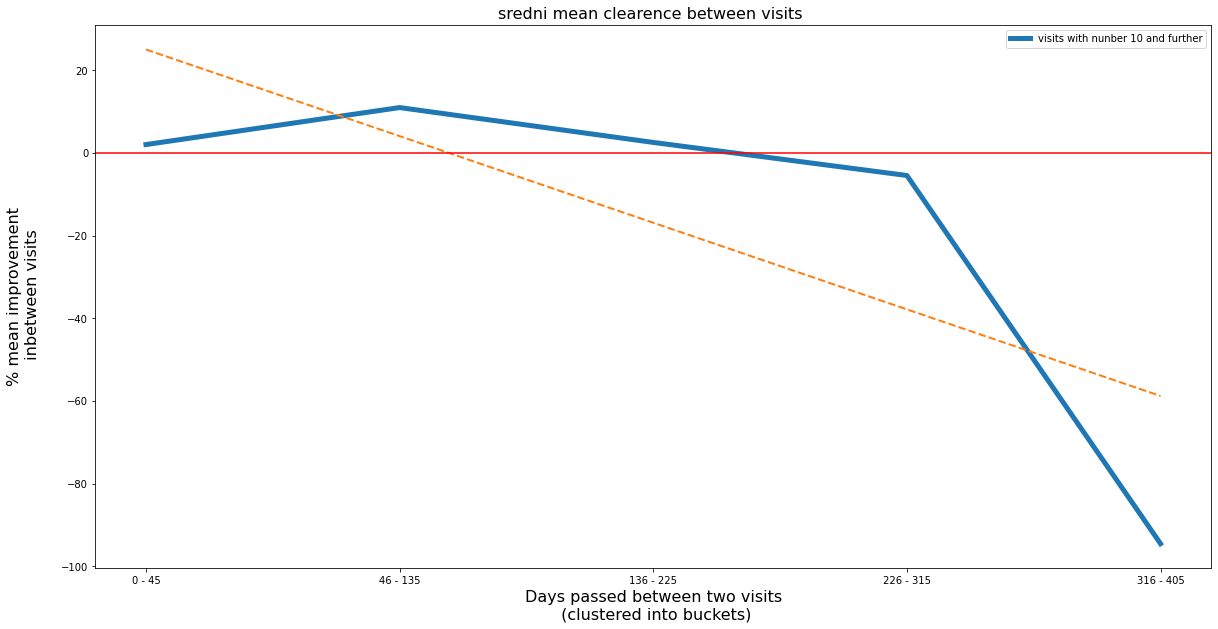

In [40]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,90,180,270,360], increment=90)

Pearsons correlation of the linear fit for visits with nunber 10 and further: -0.675 (very bad practice though)


ValueError: Grouper for 'days passed' not 1-dimensional

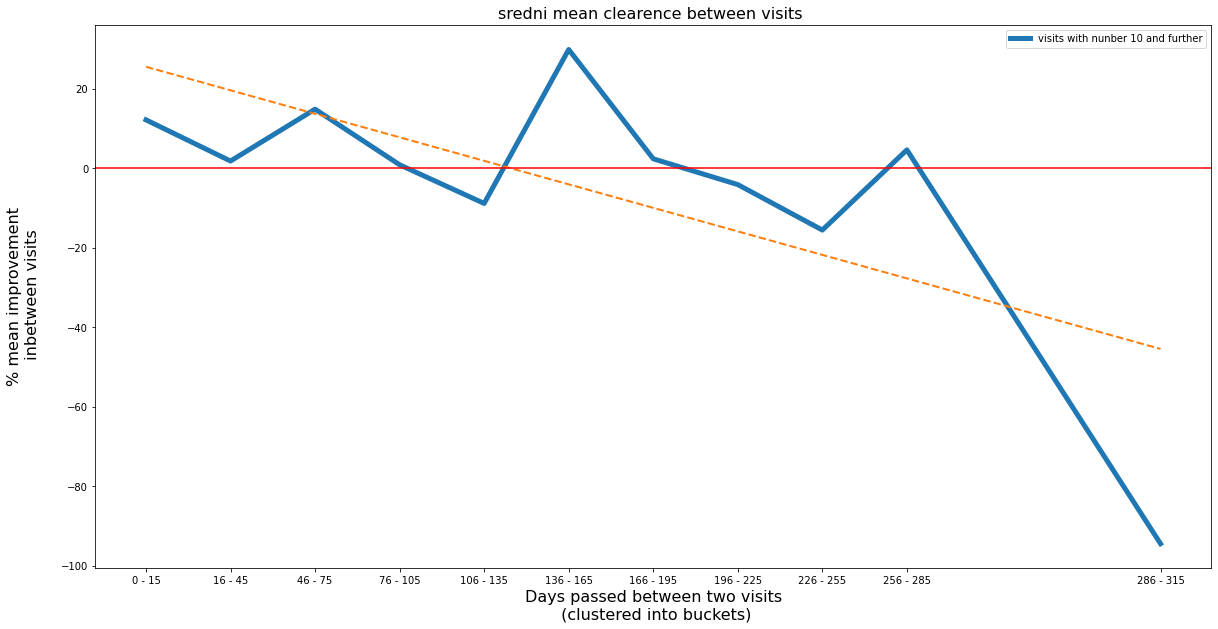

In [42]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,30,60,90,120,150,180,210,240,270,300,330,360], increment=30)

### Statistical comparison of the means between 2 samples (data divided based on time)

## Deprecated area:


In [ ]:
### All users plots:
# plot_all_users(non_moved_df, title = 'data bez zmian')
# plot_all_users(moved_df, title = 'data moved to 0s')
# plot_all_users(non0s_df, title = 'data bez 0s')
# plt.figure(figsize=(20,12))
# scatter_plot_against_time(non_moved_df, label = 'before or 5th visit', label2 ='line fit to ALL data' ,plot_linear_fit = False)
## Scatter plots - dependent on visit:
# plt.figure(figsize=(20,12))
# scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 2], label = 'before or 5th visit', label2 ='line fit to ALL data' ,plot_linear_fit = True)
## Scatter plots - dependent on visit:
# plt.figure(figsize=(30,15))

# df1 = non_moved_df.loc[non_moved_df['visit_number'].isin([1,2])]
# df2 = non_moved_df.loc[non_moved_df['visit_number'].isin([3,4,5])]
# df3 = non_moved_df.loc[non_moved_df['visit_number'].isin([6,7,8,9,10,11,12,13])]
# df5 = non_moved_df.loc[non_moved_df['visit_number'] > 13]


# scatter_plot_against_time(df1, label = 'visit nr 0-2', plot_linear_fit= False)
# scatter_plot_against_time(df2, label = 'visit nr 3-5', plot_linear_fit= False)
# scatter_plot_against_time(df3, label = 'visit nr 6-13', plot_linear_fit= False)
# scatter_plot_against_time(df5, label = 'visit nr 13+', plot_linear_fit= False)
# plt.legend()
# weird_data = non_moved_df.loc[(non_moved_df['below 0'] == True) & (non_moved_df['time'] <75)] # Send to Michal & Professor
# weird_data.to_excel('dziwne_badania.xlsx')
# plt.figure(figsize=(20,12))
# scatter_plot_against_time(non_moved_df, label = 'before or 2th visit', label2 ='line fit to ALL data')
# scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 2], label = 'after 2th visit', label2= 'line fit to 2+ visits data')
# plt.legend()
# print('If time was longer than 360 I changed it to 360 to keep graph readable \n')

# plt.figure(figsize=(20,12))
# scatter_plot_against_time(non_moved_df, label = 'before or 5th visit', label2 ='line fit to ALL data')
# scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 5], label = 'after 5th visit', label2= 'line fit to 5+ visits data')
# plt.legend()
# plt.figure(figsize=(20,12))
# scatter_plot_against_time(non_moved_df, label = 'before or 10th visit', label2 ='line fit to ALL data')
# scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 10], label = 'after 10th visit', label2= 'line fit to 10+ visits data')
# plt.legend()
# plt.figure(figsize=(20,12))
# scatter_plot_against_time(non_moved_df, label = 'before or 15th visit', label2 ='line fit to ALL data')
# scatter_plot_against_time(non_moved_df.loc[non_moved_df['visit_number'] > 15], label = 'after 15th visit', label2= 'line fit to 15+ visits data')
# plt.legend()
### Scatted plots - divided into time groups:
# plt.figure(figsize=(12,12))
# df0 = non_moved_df
# df1 = non_moved_df.loc[non_moved_df['time'] > 90]
# df2 = non_moved_df.loc[non_moved_df['time'] > 180]
# df3 = non_moved_df.loc[non_moved_df['time'] > 270]
# df4 = non_moved_df.loc[non_moved_df['time'] > 360]


# scatter_plot_against_time(df0, label = 'all data points', label2 ='line fit to ALL data',plot_linear_fit = False)
# scatter_plot_against_time(df1, label = 'days passed > 90', label2 ='',plot_linear_fit = False)
# scatter_plot_against_time(df2, label = 'days passed > 180', label2 ='',plot_linear_fit = False)
# scatter_plot_against_time(df3, label = 'days passed > 270', label2 ='',plot_linear_fit = False)
# scatter_plot_against_time(df4, label = 'days passed > 360', label2 ='',plot_linear_fit = False)
# plt.legend()
# plt.figure(figsize=(12,12))
# df0 = non_moved_df
# df1 = non_moved_df.loc[non_moved_df['time'] > 90]
# df2 = non_moved_df.loc[non_moved_df['time'] > 180]
# df3 = non_moved_df.loc[non_moved_df['time'] > 270]


# scatter_plot_against_time(df0, label = 'all data points', label2 ='line fit to ALL data')
# scatter_plot_against_time(df1, label = 'days passed > 90', label2 ='')
# scatter_plot_against_time(df2, label = 'days passed > 180', label2 ='')
# scatter_plot_against_time(df3, label = 'days passed > 270', label2 ='')
# plt.legend()
## Scatter plots - clearnce vs visit_nr
# plt.figure(figsize=(12,12))
# scatter_plot_against_visit_nr(non_moved_df, label = 'all  visits', label2 ='line fit to ALL data')
# plt.legend()
# plt.figure(figsize=(12,12))
# scatter_plot_against_visit_nr(non_moved_df, label = 'all  visits', label2 ='line fit to ALL data', plot_type='box', plot_linear_fit = False)
# plt.legend()
# plt.figure(figsize=(12,12))
# scatter_plot_against_visit_nr(non_moved_df, label = 'all  visits', label2 ='line fit to ALL data', plot_type='box', plot_linear_fit = True)
# plt.legend()